# Feature Engineering – Proyecto BigData Soccer Market Analytics

En este notebook transformamos el dataset limpio (`dataset_ready.csv`) en un dataset listo para modelado.  

Las tareas principales son:  
- Crear métricas por 90 minutos (Gls/90, Ast/90, xG/90, etc.).  
- Generar variables agregadas (G+A, xG+xAG).  
- Normalizar posiciones (GK, DF, MF, FW).  
- Codificar variables categóricas (posición, liga, nacionalidad).  
- Aplicar log-transform a `market_value_in_eur`.  
- Guardar dataset final en `data/processed/dataset_model.csv`.  


In [32]:
# ========================================
# FIX: unificar columna de valor de mercado
# ========================================

if "market_value_in_eur_x" in df.columns:
    df.rename(columns={"market_value_in_eur_x": "market_value_in_eur"}, inplace=True)
    df.drop(columns=[col for col in ["market_value_in_eur_y"] if col in df.columns], inplace=True)
elif "market_value_in_eur_y" in df.columns:
    df.rename(columns={"market_value_in_eur_y": "market_value_in_eur"}, inplace=True)

print("[i] Columnas después del fix:", df.columns.tolist())


[i] Columnas después del fix: ['Player', 'Squad', 'Nation', 'Pos', 'Comp', 'Age', 'Born', 'season', 'Competition', 'player_key', 'squad_key', 'season_key', 'comp_key', 'Rk', 'standard__Playing Time MP', 'standard__Playing Time Starts', 'standard__Playing Time Min', 'standard__Playing Time 90s', 'standard__Performance Gls', 'standard__Performance Ast', 'standard__Performance G+A', 'standard__Performance G-PK', 'standard__Performance PK', 'standard__Performance PKatt', 'standard__Performance CrdY', 'standard__Performance CrdR', 'standard__Expected xG', 'standard__Expected npxG', 'standard__Expected xAG', 'standard__Expected npxG+xAG', 'standard__Progression PrgC', 'standard__Progression PrgP', 'standard__Progression PrgR', 'standard__Per 90 Minutes Gls', 'standard__Per 90 Minutes Ast', 'standard__Per 90 Minutes G+A', 'standard__Per 90 Minutes G-PK', 'standard__Per 90 Minutes G+A-PK', 'standard__Per 90 Minutes xG', 'standard__Per 90 Minutes xAG', 'standard__Per 90 Minutes xG+xAG', 'standa

                       Player     season  market_value_in_eur
0             Anthony Khelifa  2022-2023                  0.0
1             Ben Hamed Touré  2022-2023                  0.0
2              Benjamin Leroy  2022-2023             600000.0
3          Bevic Moussiti-Oko  2022-2023             700000.0
4               Clément Vidal  2022-2023            1500000.0
5              Cyrille Bayala  2022-2023            1000000.0
6               Cédric Avinel  2022-2023             300000.0
7             Fernand Mayembo  2022-2023             700000.0
8           Florian Chabrolle  2022-2023             250000.0
9   François-Joseph Sollacaro  2022-2023             300000.0
10       Ghjuvanni Quilichini  2022-2023             200000.0
11               Ivane Chegra  2022-2023                  0.0
12            Kevin Spadanuda  2022-2023             800000.0
13          Mathieu Coutadeur  2022-2023             250000.0
14           Mickaël Alphonse  2022-2023             300000.0
15      

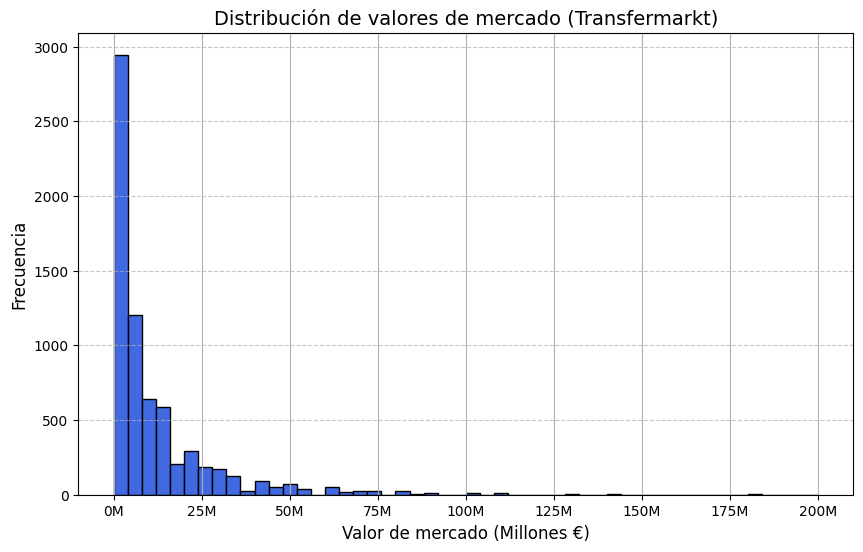

In [34]:
print(df[["Player", "season", "market_value_in_eur"]].head(20))
print("Valores únicos en mercado:", df["market_value_in_eur"].nunique())

import matplotlib.ticker as mtick

# Histograma en millones de euros
plt.figure(figsize=(10,6))
(df["market_value_in_eur"] / 1e6).hist(bins=50, color="royalblue", edgecolor="black")

plt.xlabel("Valor de mercado (Millones €)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.title("Distribución de valores de mercado (Transfermarkt)", fontsize=14)

# Formato de eje X (0M, 50M, 100M...)
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x)}M"))

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


[✓] Dataset final guardado en ../data/processed/dataset_model.csv
[i] Filas: 6849  Columnas: 275


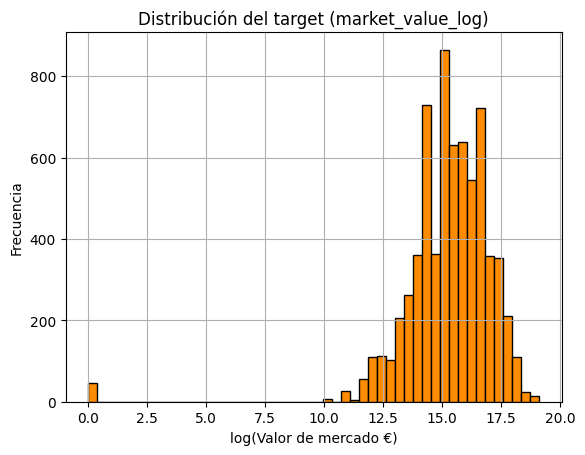

In [38]:
# ========================================
# Feature Engineering completo
# ========================================

# Evitar divisiones por cero en métricas por 90
df["Min_per_90"] = df["standard__Playing Time Min"] / 90
df["Min_per_90"] = df["Min_per_90"].replace(0, np.nan)

# Métricas ofensivas por 90’
df["Gls_per90"] = df["standard__Performance Gls"] / df["Min_per_90"]
df["Ast_per90"] = df["standard__Performance Ast"] / df["Min_per_90"]
df["xG_per90"]  = df["standard__Expected xG"] / df["Min_per_90"]
df["xAG_per90"] = df["standard__Expected xAG"] / df["Min_per_90"]

# Variables agregadas
df["GA"] = df["standard__Performance Gls"] + df["standard__Performance Ast"]
df["xG_xAG"] = df["standard__Expected xG"] + df["standard__Expected xAG"]

# Normalizar posiciones principales
def simplify_position(pos):
    if "GK" in pos: return "GK"
    elif "DF" in pos: return "DF"
    elif "MF" in pos: return "MF"
    elif "FW" in pos: return "FW"
    else: return "Other"

df["MainPos"] = df["Pos"].astype(str).apply(simplify_position)

# One-hot encoding de categóricas relevantes
df_encoded = pd.get_dummies(
    df,
    columns=["MainPos", "Comp", "Nation"],
    drop_first=True
)

# Target: log-transform del valor de mercado
df_encoded["market_value_log"] = np.log1p(df_encoded["market_value_in_eur"])

# Guardar dataset final procesado
output_path = "../data/processed/dataset_model.csv"
df_encoded.to_csv(output_path, index=False)

print(f"[✓] Dataset final guardado en {output_path}")
print("[i] Filas:", df_encoded.shape[0], " Columnas:", df_encoded.shape[1])

# Chequeo rápido del target
df_encoded["market_value_log"].hist(bins=50, color="darkorange", edgecolor="black")
plt.xlabel("log(Valor de mercado €)")
plt.ylabel("Frecuencia")
plt.title("Distribución del target (market_value_log)")
plt.show()
